In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
from skimage import io
from skimage.io import imread,imshow
from itertools import chain
import pydicom

import matplotlib.image as mpimg #read png files
##Import any other packages you may need here
import matplotlib.image as image
from scipy.ndimage import gaussian_filter
import scipy
from IPython.display import clear_output

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
1907,00009995_016.png,No Finding,16,9995,063Y,M,PA,2886,2741,0.143,0.143
2952,00014520_014.png,No Finding,14,14520,032Y,M,AP,2048,2500,0.168,0.168
408,00002122_002.png,No Finding,2,2122,049Y,F,PA,2992,2991,0.143,0.143


In [3]:
## EDA
# Todo 
pd.set_option('display.max_columns', None)
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [4]:
all_labels=np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels=[x for x in all_labels if len(x)>0]
print(all_labels)

for label in all_labels:
    if len(label)>1:
        all_xray_df[label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0)

        
all_xray_df.head()

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:

all_xray_df.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,0.0,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649,NaN,0.103095,0.024759,0.041625,0.020540,0.118775,0.022440,0.015037,0.002025,0.177435,0.051570,0.538361,0.056466,0.030191,0.012763,0.047289
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174,NaN,0.304084,0.155391,0.199732,0.141841,0.323524,0.148111,0.121702,0.044950,0.382038,0.221158,0.498529,0.230821,0.171113,0.112251,0.212256
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 27 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
 12  Atelectasis                  112120 non-null  float64
 13 

In [7]:
# unique_labels = np.unique(list(chain(*labels)))
# for each case (row), make a binary flag for whether this person has a disease or not
for ul in all_labels:
    all_xray_df[ul] = all_xray_df['Finding Labels'].map(lambda finding: 1 if ul in finding else 0)
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


Healthy people count: 60361
Diseased people count: 51759


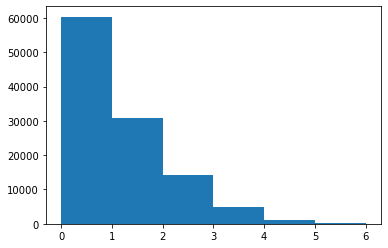

In [8]:
# count number of diseases each person has
split_findings = all_xray_df['Finding Labels'].map(lambda x: x.split('|'))
all_xray_df['Disease Count'] = split_findings.map(lambda x: len(x) if 'No Finding' not in x else 0)
# plot histogram
plt.hist(all_xray_df['Disease Count'], bins=np.arange(0, 7, 1));
print('Healthy people count:', len(all_xray_df[all_xray_df['Disease Count'] == 0]))
print('Diseased people count:', len(all_xray_df[all_xray_df['Disease Count'] > 0]))

In [9]:
penumonia_pos_count = len(all_xray_df[all_xray_df.Pneumonia == 1])
penumonia_neg_count = len(all_xray_df[all_xray_df.Pneumonia == 0])
print('Patients positive for pneumonia', penumonia_pos_count)
print('Patients negative for pneumonia', penumonia_neg_count)

Patients positive for pneumonia 1431
Patients negative for pneumonia 110689


In [10]:
all_xray_df[all_xray_df['Patient Age']<100].describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Disease Count
count,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,0.0,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000
mean,8.574172,14345.720724,46.872574,2646.035253,2486.393153,0.155651,0.155651,NaN,0.103101,0.024763,0.041631,0.020535,0.118783,0.022443,0.015040,0.002025,0.177433,0.051550,0.538366,0.056474,0.030186,0.012756,0.047286,0.724006
std,15.406734,8403.980520,16.598152,341.243771,401.270806,0.016174,0.016174,NaN,0.304092,0.155402,0.199745,0.141820,0.323534,0.148121,0.121711,0.044954,0.382037,0.221118,0.498528,0.230836,0.171100,0.112220,0.212252,0.963213
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7308.000000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,183.000000,30805.000000,95.000000,3827.000000,4715.000000,0.198800,0.198800,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.000000


In [11]:
all_xray_df[all_xray_df['Patient Age']>100]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Disease Count
20852,00005567_000.png,Effusion|Pneumonia,0,5567,412,M,AP,3056,2544,0.139,0.139,NaN,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,2
46965,00011973_002.png,Edema,2,11973,414,M,AP,3056,2544,0.139,0.139,NaN,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
48284,00012238_010.png,No Finding,10,12238,148,M,PA,2992,2991,0.143,0.143,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
55742,00013950_000.png,No Finding,0,13950,148,M,PA,2964,2939,0.143,0.143,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
58650,00014520_026.png,Infiltration|Mass,26,14520,150,M,PA,2992,2991,0.143,0.143,NaN,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,2
62929,00015558_000.png,No Finding,0,15558,149,M,PA,2992,2991,0.143,0.143,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
74884,00018366_044.png,Pneumothorax,44,18366,152,F,PA,2302,2991,0.143,0.143,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
78795,00019346_000.png,Infiltration,0,19346,151,F,PA,2678,2774,0.143,0.143,NaN,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
84810,00020900_002.png,No Finding,2,20900,411,M,AP,3056,2544,0.139,0.139,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
85404,00021047_002.png,Mass|Pleural_Thickening,2,21047,412,M,AP,3056,2544,0.139,0.139,NaN,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,2


Demographic data

Age

Text(0.5, 0, 'Patient Age')

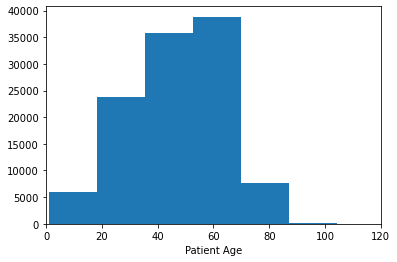

In [12]:
#Age distribution
plt.hist(all_xray_df['Patient Age'],bins=24)
plt.xlim(0,120)
plt.xlabel('Patient Age')

In [13]:
all_xray_df[all_xray_df['Patient Age'] > 100]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Disease Count
20852,00005567_000.png,Effusion|Pneumonia,0,5567,412,M,AP,3056,2544,0.139,0.139,NaN,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,2
46965,00011973_002.png,Edema,2,11973,414,M,AP,3056,2544,0.139,0.139,NaN,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
48284,00012238_010.png,No Finding,10,12238,148,M,PA,2992,2991,0.143,0.143,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
55742,00013950_000.png,No Finding,0,13950,148,M,PA,2964,2939,0.143,0.143,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
58650,00014520_026.png,Infiltration|Mass,26,14520,150,M,PA,2992,2991,0.143,0.143,NaN,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,2
62929,00015558_000.png,No Finding,0,15558,149,M,PA,2992,2991,0.143,0.143,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
74884,00018366_044.png,Pneumothorax,44,18366,152,F,PA,2302,2991,0.143,0.143,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
78795,00019346_000.png,Infiltration,0,19346,151,F,PA,2678,2774,0.143,0.143,NaN,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
84810,00020900_002.png,No Finding,2,20900,411,M,AP,3056,2544,0.139,0.139,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
85404,00021047_002.png,Mass|Pleural_Thickening,2,21047,412,M,AP,3056,2544,0.139,0.139,NaN,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,2


Notice that some patients have ages 412, 150, etc. These are invalid ages and the record should be thrown out.

In [14]:
# drop patients with ages over 110
all_xray_df = all_xray_df[all_xray_df['Patient Age'] <= 110]

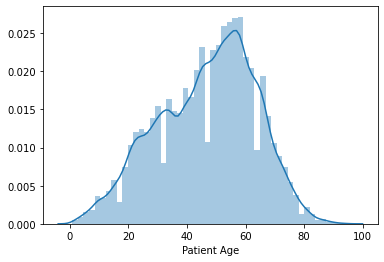

In [15]:
# age distribution for all patients
sns.distplot(all_xray_df['Patient Age']);

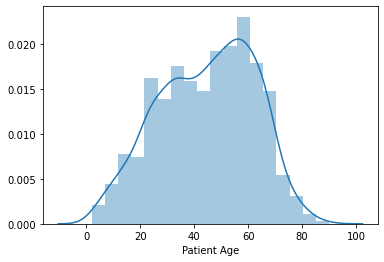

In [16]:
# age distribution for patients having Pneumonia
sns.distplot(all_xray_df.loc[all_xray_df.Pneumonia==1, 'Patient Age']);

Demographic data: Gender

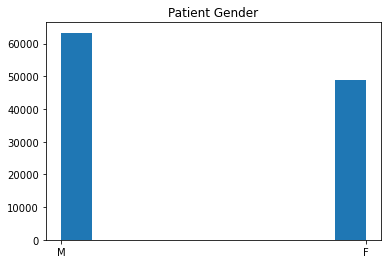

Number of Men in Data Set is M    63328
Name: Patient Gender, dtype: int64
Number of Women in Data Set is F    48776
Name: Patient Gender, dtype: int64


In [17]:
# Gender distribution
plt.hist(all_xray_df['Patient Gender'])
plt.title('Patient Gender')
plt.show()
print('Number of Men in Data Set is {}'.format(all_xray_df['Patient Gender'][(all_xray_df['Patient Gender']=='M')].value_counts()))
print('Number of Women in Data Set is {}'.format(all_xray_df['Patient Gender'][(all_xray_df['Patient Gender']=='F')].value_counts()))

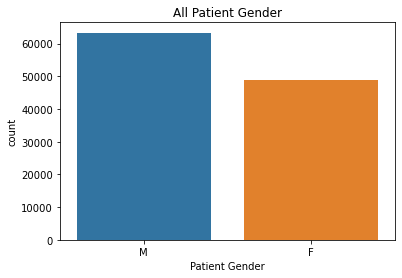

In [18]:
# Gender distribution
sns.countplot(data = all_xray_df, x = 'Patient Gender').set_title('All Patient Gender');

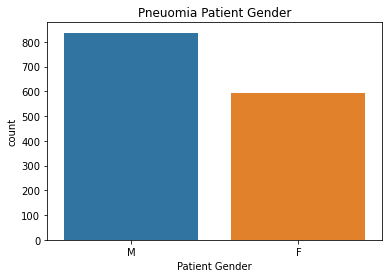

In [19]:
# Gender distribution for Pneumonia patients
sns.countplot(data = all_xray_df.loc[all_xray_df.Pneumonia==1], x = 'Patient Gender').set_title('Pneuomia Patient Gender');

In [20]:
num_male_p = all_xray_df[(all_xray_df.Pneumonia==1) & (all_xray_df['Patient Gender'] == 'M')]
num_female_p = all_xray_df[(all_xray_df.Pneumonia==1) & (all_xray_df['Patient Gender'] == 'F')]
print(f'Gender distribution for Pneumonia patients\nMale: {len(num_male_p)} ({100.0*len(num_male_p)/len(all_xray_df[(all_xray_df.Pneumonia==1)]):.2f}%), \
Female: {len(num_female_p)} ({100.0*len(num_female_p)/len(all_xray_df[(all_xray_df.Pneumonia==1)]):.2f}%)')

Gender distribution for Pneumonia patients
Male: 837 (58.53%), Female: 593 (41.47%)


View Position of X-rays

In [21]:
all_xray_df['View Position'].unique()

array(['PA', 'AP'], dtype=object)

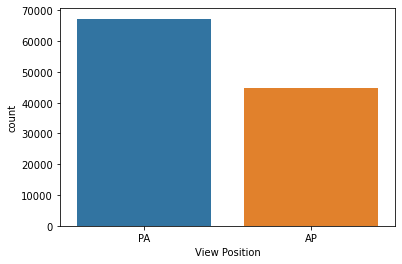

In [22]:
sns.countplot(data = all_xray_df, x = 'View Position');

In [23]:
pos_pa = all_xray_df[all_xray_df['View Position'] == 'PA']
pos_ap = all_xray_df[all_xray_df['View Position'] == 'AP']
print(f'View position value distribution\nPA: {len(pos_pa)} ({100.0*len(pos_pa)/len(all_xray_df):.2f}%), \
AP: {len(pos_ap)} ({100.0*len(pos_ap)/len(all_xray_df):.2f}%)')

View position value distribution
PA: 67299 (60.03%), AP: 44805 (39.97%)


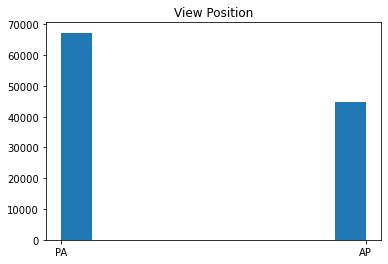

Number of XRays in PA position: PA    67299
Name: View Position, dtype: int64
Number of XRays in AP position: AP    44805
Name: View Position, dtype: int64


In [24]:
#Patient Position
plt.hist(all_xray_df['View Position'])
plt.title('View Position')
plt.show()
PA=all_xray_df['View Position'][all_xray_df['View Position']=='PA']
AP=all_xray_df['View Position'][all_xray_df['View Position']=='AP']

print('Number of XRays in PA position: ' + str(PA.value_counts()))
print('Number of XRays in AP position: ' + str(AP.value_counts()))

Follow ups

In [25]:
#Count how many unique patients
unique=all_xray_df['Patient ID'][all_xray_df['Follow-up #']==0].unique().shape[0]
print('Number of unique patients: ' + str(unique))

Number of unique patients: 30797


In [26]:
#Look at how many patients are have follow ups after first image.
repeats = all_xray_df['Patient ID'][all_xray_df['Follow-up #']>0].unique().shape[0]
print('Number of follow up patients: ' + str(repeats))

Number of follow up patients: 13301


Number of Pneumonia vs non-pneumonia cases

In [27]:
# Extract finding labels
finding_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
finding_labels

array(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
       'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax'], dtype='<U18')

In [28]:
# Create one-hot features for each finding label
for label in finding_labels:
    all_xray_df[label] = all_xray_df["Finding Labels"].map(lambda x: 1. if label in x else 0)

In [29]:
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Disease Count
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


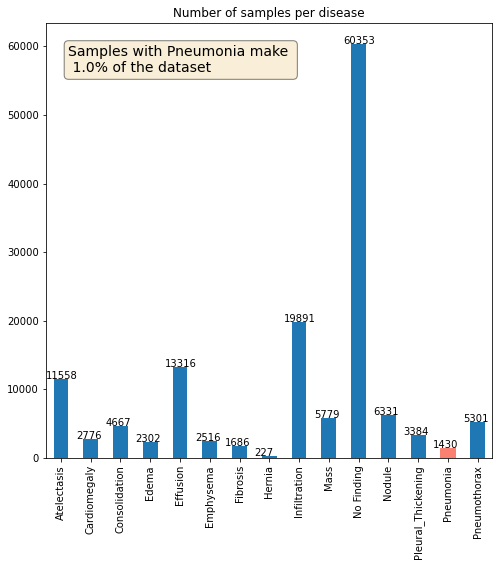

In [30]:
# Number of samples per disease
ax = all_xray_df[finding_labels].sum().plot(kind='bar', figsize = (8, 8))
ax.set_title('Number of samples per disease')

# Print values above bars
value_counts = [int(x) for x in all_xray_df[finding_labels].sum().tolist()]
for i, v in enumerate(value_counts):
    ax.text(i-0.5, v+10, str(v))
    
# Highlight info about Pneumonia 
ax.get_children()[13].set_color('salmon')

penumonia_samples_percent = round(all_xray_df.Pneumonia.sum()/len(all_xray_df), 2) * 100
text = "Samples with Pneumonia make \n "+ str(penumonia_samples_percent) + "% of the dataset"
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, text, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)

plt.show()

In [31]:
#Number of Pneumonia cases and Non-Pneumonia Cases
PositivePneu=all_xray_df[all_xray_df['Pneumonia']==1]
NegativePneu=all_xray_df[all_xray_df['Pneumonia']==0]
print('Total Pneumonia cases: '+ str(len(PositivePneu)))
print('Total Non-Pneumonia cases: {}'.format(len(NegativePneu)))
print('In this dataset, the percentage of pneumonia cases is {}%'.format(np.round(100*len(PositivePneu)/(len(PositivePneu)+len(NegativePneu)), 2)))

Total Pneumonia cases: 1430
Total Non-Pneumonia cases: 110674
In this dataset, the percentage of pneumonia cases is 1.28%


The distribution of other diseases that are comorbid with pneumonia

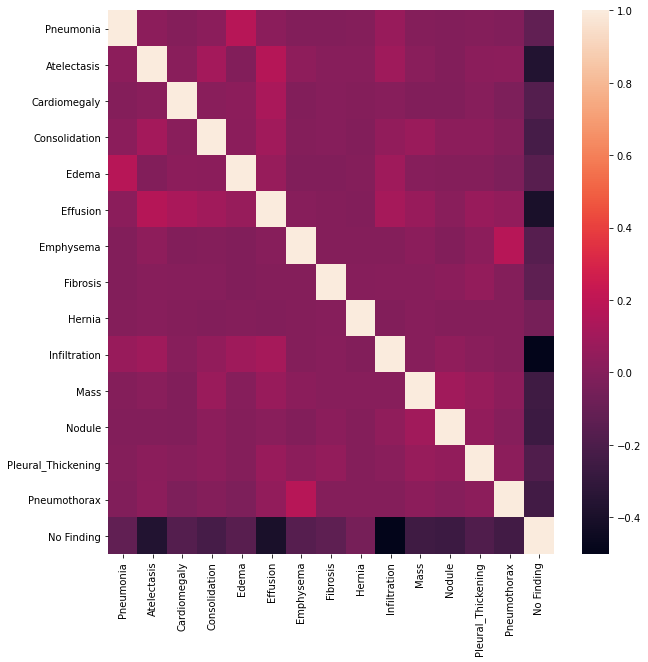

In [32]:
# distribution of other diseases that are comorbid with pneumonia
plt.figure(figsize=(10,10))
comorbid = ['Pneumonia', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumothorax', 'No Finding']
label_df = all_xray_df[comorbid]
corr_df = label_df.corr() 
sns.heatmap(corr_df);

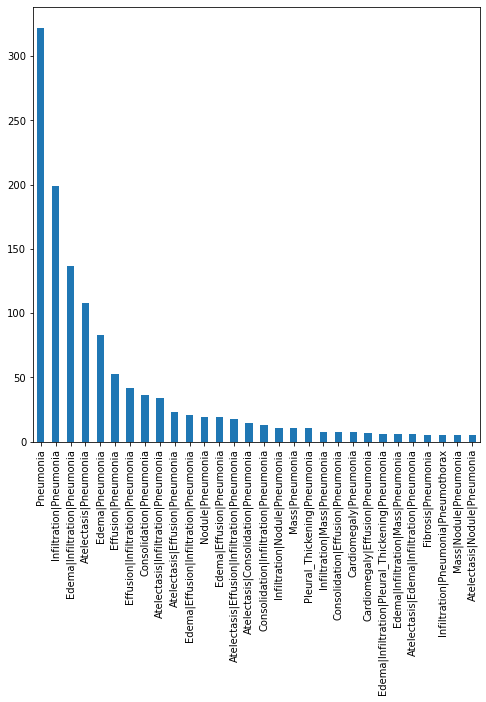

In [33]:
#Comorbitiy with other diseases
plt.figure(figsize=(8,8))
PositivePneu['Finding Labels'].value_counts()[0:30].plot(kind='bar')

In [34]:
print('Top 10 Co-morbid diseases with pneumonia: \n{}'.format(PositivePneu['Finding Labels'].value_counts()[0:10]))

Top 10 Co-morbid diseases with pneumonia: 
Pneumonia                             322
Infiltration|Pneumonia                199
Edema|Infiltration|Pneumonia          137
Atelectasis|Pneumonia                 108
Edema|Pneumonia                        83
Effusion|Pneumonia                     53
Effusion|Infiltration|Pneumonia        42
Consolidation|Pneumonia                36
Atelectasis|Infiltration|Pneumonia     34
Atelectasis|Effusion|Pneumonia         23
Name: Finding Labels, dtype: int64


Number of disease per patient

In [35]:
#Number of Disease per patient with Mean
all_xray_df['Total Disease Count']=all_xray_df[all_labels].sum(axis=1)
all_xray_df['Total Disease Count'][all_xray_df['No Finding']==1.0] = 0
print('Average Number of Diseases per Person: {}'.format(np.round(all_xray_df['Total Disease Count'].mean(),2)))

Average Number of Diseases per Person: 0.72


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [36]:
all_xray_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Disease Count,Total Disease Count
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2,2.0
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0


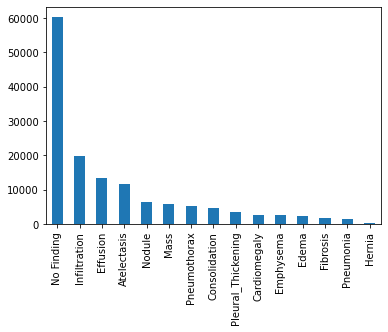

In [37]:
all_xray_df[all_labels].sum().sort_values(ascending=False).plot(kind='bar')

In [38]:
(all_xray_df['No Finding']==0).sum()

51751

(0.0, 120.0)

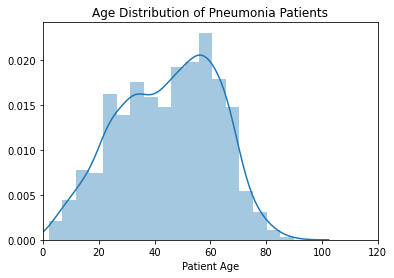

In [39]:
#Age Distribution of Pneumonia Patients
sns.distplot(PositivePneu['Patient Age'])
plt.title('Age Distribution of Pneumonia Patients')
plt.xlim(0,120)

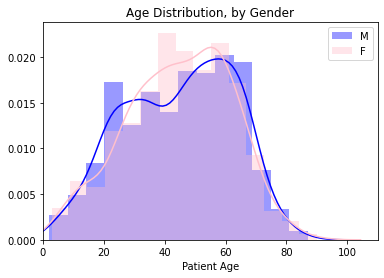

In [40]:
#Age Distribution of Pneumonia Patients, Separated by Gender
sns.distplot(PositivePneu['Patient Age'][PositivePneu['Patient Gender']=='M'],color='blue', label='M')
sns.distplot(PositivePneu['Patient Age'][PositivePneu['Patient Gender']=='F'],color='pink', label='F')
plt.title('Age Distribution, by Gender')
plt.xlim(0, 110)
plt.legend()
plt.savefig('out/Age_Distribution')

In [41]:

scipy.stats.ttest_ind(all_xray_df['Patient Age'][all_xray_df['Patient Gender']=='M'],
                      all_xray_df['Patient Age'][all_xray_df['Patient Gender']=='F'], nan_policy='omit')

Ttest_indResult(statistic=6.472498414634511, pvalue=9.679136408051127e-11)

In [42]:
#sample_df will be used for this EDA

samp_labels=np.unique(list(chain(*sample_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
samp_labels=[x for x in samp_labels if len(x) > 0]
print(samp_labels)


for label in all_labels:
    sample_df[label] = sample_df['Finding Labels'].map(lambda finding: 1 if label in finding else 0)
        
sample_df.head()

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0


In [43]:
image_name = sample_df[sample_df['Pneumonia']==1]['Image Index'].sample().item()
image_name

'00026994_002.png'

In [44]:
image_paths = {os.path.basename(x): x for x in glob(os.path.join('/data','images*', '*', '*.png'))}
image_paths



{'00019124_042.png': '/data/images_009/images/00019124_042.png',
 '00019576_024.png': '/data/images_009/images/00019576_024.png',
 '00019545_003.png': '/data/images_009/images/00019545_003.png',
 '00020065_000.png': '/data/images_009/images/00020065_000.png',
 '00020356_000.png': '/data/images_009/images/00020356_000.png',
 '00019962_003.png': '/data/images_009/images/00019962_003.png',
 '00018936_005.png': '/data/images_009/images/00018936_005.png',
 '00018562_007.png': '/data/images_009/images/00018562_007.png',
 '00020326_026.png': '/data/images_009/images/00020326_026.png',
 '00018704_000.png': '/data/images_009/images/00018704_000.png',
 '00020383_004.png': '/data/images_009/images/00020383_004.png',
 '00019576_021.png': '/data/images_009/images/00019576_021.png',
 '00019742_008.png': '/data/images_009/images/00019742_008.png',
 '00020326_018.png': '/data/images_009/images/00020326_018.png',
 '00020187_002.png': '/data/images_009/images/00020187_002.png',
 '00019847_004.png': '/da

In [45]:
def image_distribution(img_data):
    f = plt.figure()
    f.set_figwidth(10)
    s1 = f.add_subplot(1, 2, 1)
    s1.set_title('Image')
    plt.imshow(img_data, cmap='gray')
    s2 = f.add_subplot(1, 2, 2)
    s2.set_title('Intensity Distribution')
    plt.hist(img_data.ravel(), bins = 256)
    plt.xlim((10,255))
    plt.ylim((0,15000))
    plt.show()

00026994_002.png


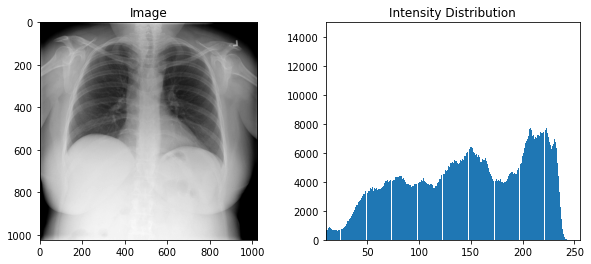

In [46]:
from skimage import io
print(image_name)

img_data = io.imread(image_paths[image_name])

image_distribution(img_data)

Pixel level assessments

In [47]:
# Visualize some images
images = []
for i, img_id in enumerate(sample_df['Image Index']):
    clear_output(wait=True)
    path = glob(os.path.join("/data","images*","*",img_id))[0]
    print("Loaded {}/{}".format(i+1, len(sample_df)))
    img = io.imread(path)
    images.append(img)

Loaded 5606/5606


In [48]:
intensity_images = []
for i, image in enumerate(images):
    clear_output(wait=True)
    intensity_images.append(np.mean(image))
    print("Done {}/{}".format(i, len(images)))
intensity_images = np.array(intensity_images)

Done 5605/5606


In [49]:
pneumonia_intensity = intensity_images[sample_df[sample_df["Finding Labels"].str.contains("Pneumonia")].index]

(array([ 4.,  8., 16., 13., 10.,  4.,  0.,  3.,  3.,  1.]),
 array([ 88.1964426 ,  98.5581321 , 108.9198216 , 119.28151109,
        129.64320059, 140.00489008, 150.36657958, 160.72826908,
        171.08995857, 181.45164807, 191.81333756]),
 <a list of 10 Patch objects>)

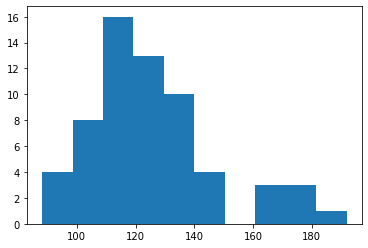

In [50]:
plt.hist(pneumonia_intensity)

The distribution of the pixel intensities for Pneumonia has a peak at 110.

(array([  3.,   6.,  14.,  67., 341., 272., 143.,  91.,  23.,   7.]),
 array([ 41.29449272,  56.17974558,  71.06499844,  85.95025129,
        100.83550415, 115.72075701, 130.60600986, 145.49126272,
        160.37651558, 175.26176844, 190.14702129]),
 <a list of 10 Patch objects>)

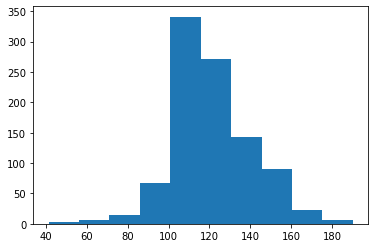

In [51]:
infiltration_intensity = intensity_images[sample_df[sample_df["Finding Labels"].str.contains("Infiltration")].index]
plt.hist(infiltration_intensity)

The distribution of the pixel intensities for Infiltration has a peak at 100 which is very close to that of Pneumonia's peak at 110.

(array([  2.,   1.,  12.,  72., 227., 159.,  75.,  67.,  23.,   6.]),
 array([ 44.95568371,  59.80278091,  74.64987812,  89.49697533,
        104.34407253, 119.19116974, 134.03826694, 148.88536415,
        163.73246136, 178.57955856, 193.42665577]),
 <a list of 10 Patch objects>)

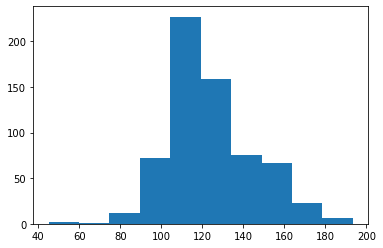

In [52]:
effusion_intensity = intensity_images[sample_df[sample_df["Finding Labels"].str.contains("Effusion")].index]
plt.hist(effusion_intensity)

The distribution of the pixel intensities for Effusion has a peak at 110 which is the same as Pneumonia.

edema_intensity = intensity_images[sample_df[sample_df["Finding Labels"].str.contains("Edema")].index]
plt.hist(edema_intensity)

In [ ]:
The distribution of the pixel intensities for Edema has a peak at 110 which is the same as Pneumonia's peak at 110.

(array([   9.,   21.,   88.,  715., 2131., 1255.,  702.,  575.,  102.,
           8.]),
 array([ 37.45602131,  54.76187196,  72.06772261,  89.37357326,
        106.6794239 , 123.98527455, 141.2911252 , 158.59697585,
        175.9028265 , 193.20867715, 210.5145278 ]),
 <a list of 10 Patch objects>)

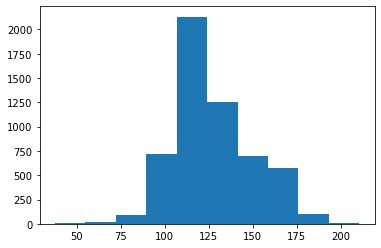

In [54]:
plt.hist(intensity_images)

In [55]:

sample_df.head(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [56]:


labels = ['Pneumonia', 'No Finding', 'Infiltration', 'Edema', 'Effusion', 'Atelectasis']

for i in labels:
    print(i, 'Images:\n',sample_df[sample_df['Finding Labels']==i]['Image Index'].head(6),'\n') 
    


Pneumonia Images:
 1631    00008470_008.png
2286    00011702_043.png
2422    00012158_025.png
2522    00012667_000.png
2534    00012733_000.png
2875    00014201_008.png
Name: Image Index, dtype: object 

No Finding Images:
 2     00000017_001.png
6     00000042_002.png
7     00000057_001.png
9     00000061_019.png
12    00000080_005.png
13    00000083_000.png
Name: Image Index, dtype: object 

Infiltration Images:
 32    00000181_017.png
33    00000181_035.png
44    00000246_011.png
48    00000250_005.png
51    00000268_001.png
63    00000360_008.png
Name: Image Index, dtype: object 

Edema Images:
 225    00001249_002.png
243    00001301_020.png
282    00001504_009.png
460    00002412_000.png
486    00002533_003.png
782    00004090_002.png
Name: Image Index, dtype: object 

Effusion Images:
 8      00000061_002.png
14     00000084_000.png
15     00000096_006.png
16     00000099_003.png
25     00000127_007.png
115    00000632_011.png
Name: Image Index, dtype: object 

Atelectasis Image

In [57]:

# find the images - they are not in the same folder as the source 

!ls /data

ARXIV_V5_CHESTXRAY.pdf	images_002  images_007	images_012
BBox_List_2017.csv	images_003  images_008	LOG_CHESTXRAY.pdf
Data_Entry_2017.csv	images_004  images_009	README_CHESTXRAY.pdf
FAQ_CHESTXRAY.pdf	images_005  images_010	test_list.txt
images_001		images_006  images_011	train_val_list.txt


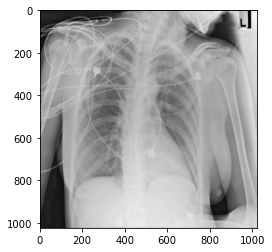

In [58]:
Pneumonia_1= plt.imread('/data/images_004/images/00008470_008.png') 
plt.imshow(Pneumonia_1, cmap='gray')

In [59]:
# Read sample image by using the image path
Pneumonia=[]
Pneumonia.append(plt.imread('/data/images_006/images/00012667_000.png')) 
Pneumonia.append(plt.imread('/data/images_006/images/00012733_000.png'))
Pneumonia.append(plt.imread('/data/images_006/images/00012158_025.png'))

Healthy=[]
Healthy.append(plt.imread('/data/images_001/images/00000017_001.png')) 
Healthy.append(plt.imread('/data/images_001/images/00000042_002.png'))
Healthy.append(plt.imread('/data/images_001/images/00000080_005.png'))

Infiltration=[]
Infiltration.append(plt.imread('/data/images_001/images/00000490_000.png')) 
Infiltration.append(plt.imread('/data/images_001/images/00000246_011.png'))
Infiltration.append(plt.imread('/data/images_001/images/00000360_008.png'))

Edema=[]
Edema.append(plt.imread('/data/images_002/images/00002412_000.png')) 
Edema.append(plt.imread('/data/images_002/images/00002533_003.png'))
Edema.append(plt.imread('/data/images_002/images/00001504_009.png'))

Effusion=[]
Effusion.append(plt.imread('/data/images_001/images/00000632_011.png')) 
Effusion.append(plt.imread('/data/images_001/images/00000099_003.png'))
Effusion.append(plt.imread('/data/images_001/images/00000096_006.png'))

Atelectasis=[]
Atelectasis.append(plt.imread('/data/images_001/images/00000030_001.png')) 
Atelectasis.append(plt.imread('/data/images_001/images/00000642_000.png'))
Atelectasis.append(plt.imread('/data/images_001/images/00000816_000.png'))

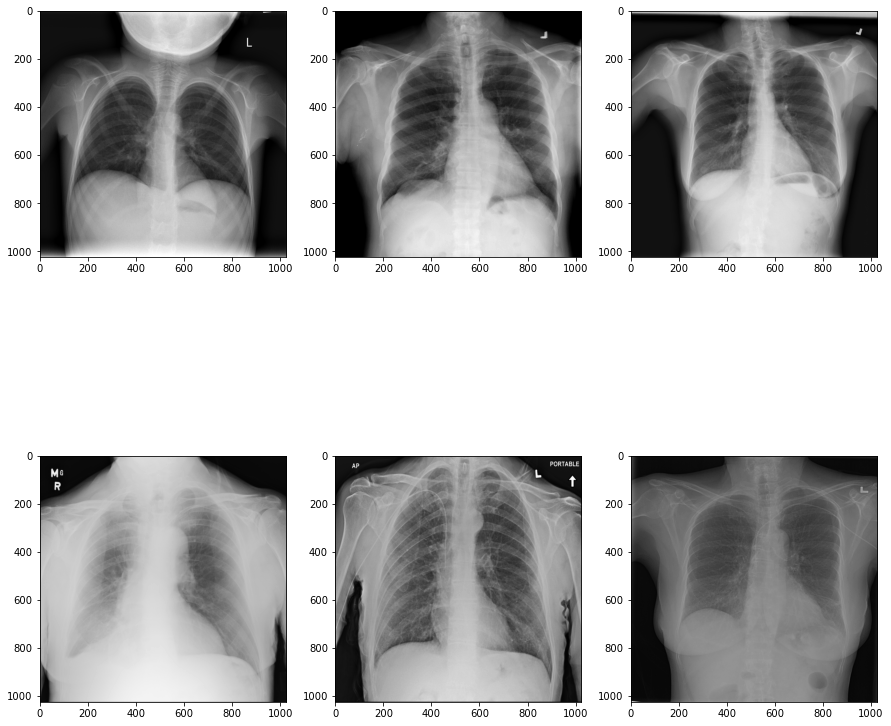

In [60]:

plt.figure(figsize=(15,15))

for i,j,k in zip((0,1,2), (1,2,3), (4,5,6)):
    plt.subplot(2,3,j), plt.imshow(Pneumonia[i], cmap='gray')
    plt.subplot(2,3,k), plt.imshow(Healthy[i], cmap='gray')

Pneumonia vs. other diseases.
Compare Pneumonia with all the other diseases.

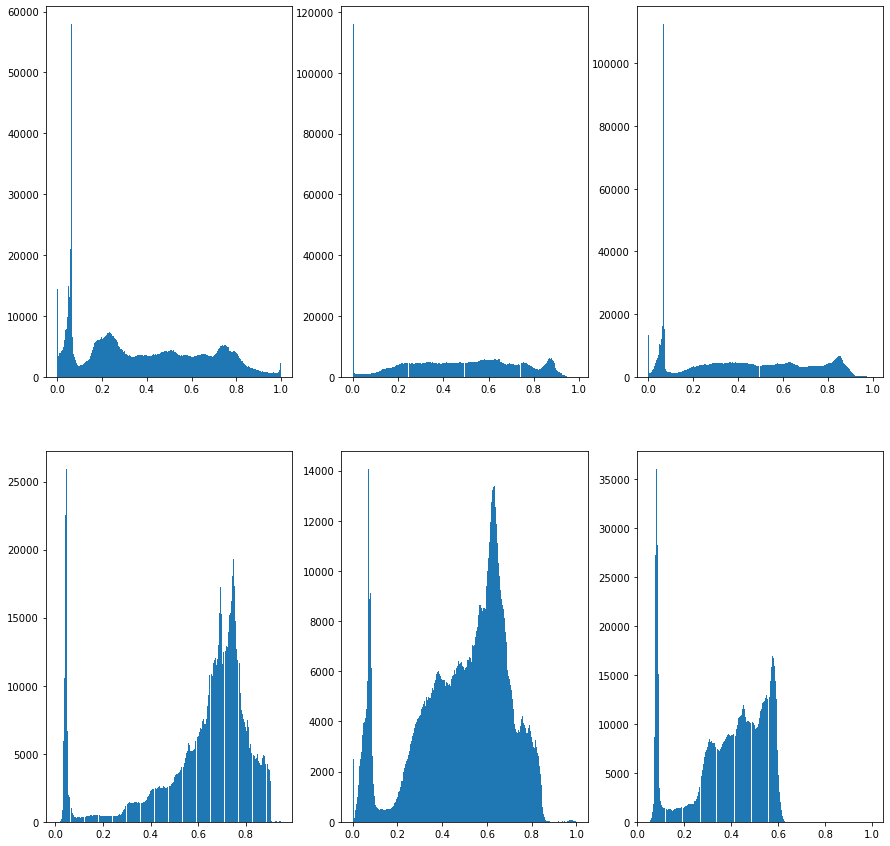

In [61]:
# look at the pixel intensities

plt.figure(figsize=(15,15))

for i,j,k in zip((0,1,2), (1,2,3), (4,5,6)):
    plt.subplot(2,3,j), plt.hist(Pneumonia[i].ravel(), bins=256)
    plt.subplot(2,3,k), plt.hist(Healthy[i].ravel(), bins=256)

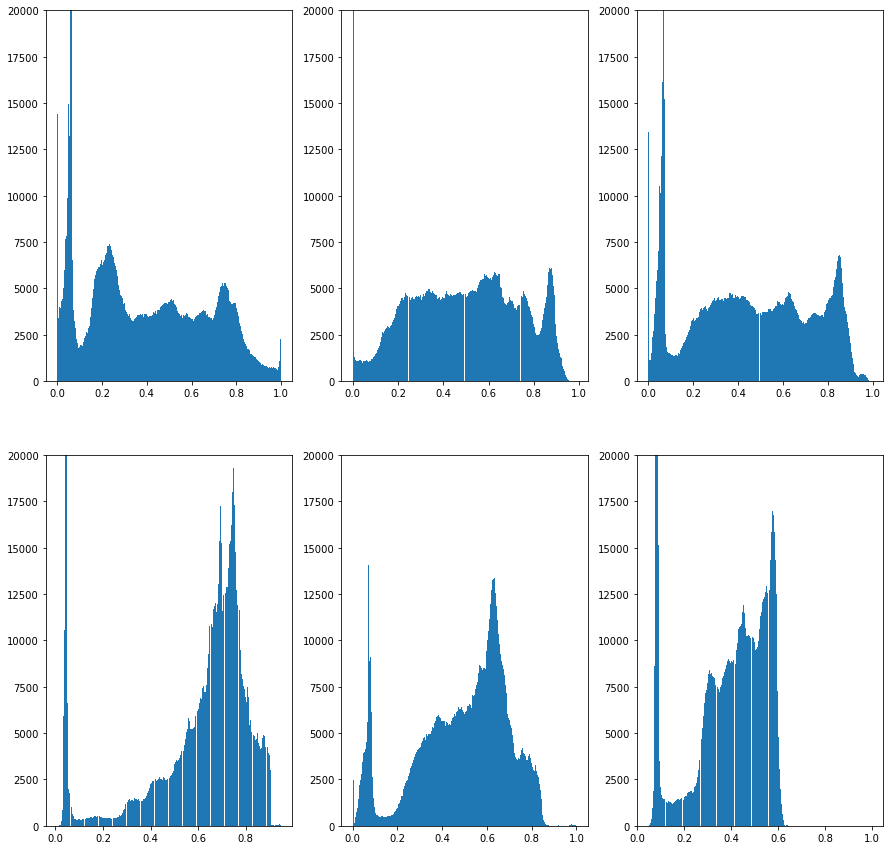

In [62]:
# set the y axis limit to 20000 for compaison of the intensity profiles:

plt.figure(figsize=(15,15))

for i,j,k in zip((0,1,2), (1,2,3), (4,5,6)):
    plt.subplot(2,3,j), plt.hist(Pneumonia[i].ravel(), bins=256)
    plt.ylim(0, 20000)
    plt.subplot(2,3,k), plt.hist(Healthy[i].ravel(), bins=256)
    plt.ylim(0, 20000)

In [63]:
# Mean:
print("Pneumonia mean intensity:", np.mean(Pneumonia))
print("Healthy mean intensity:", np.mean(Healthy))

Pneumonia mean intensity: 0.41915622
Healthy mean intensity: 0.5003894


Text(0.5, 1.0, 'No Finding AP Position')

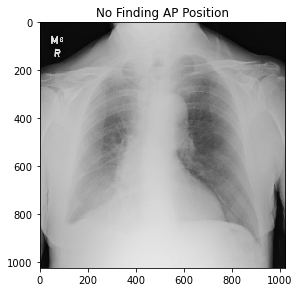

In [64]:
#AP Position
sampimg1=imread('/data/images_001/images/00000017_001.png')
imshow(sampimg1, cmap='gray')
plt.title('No Finding AP Position')

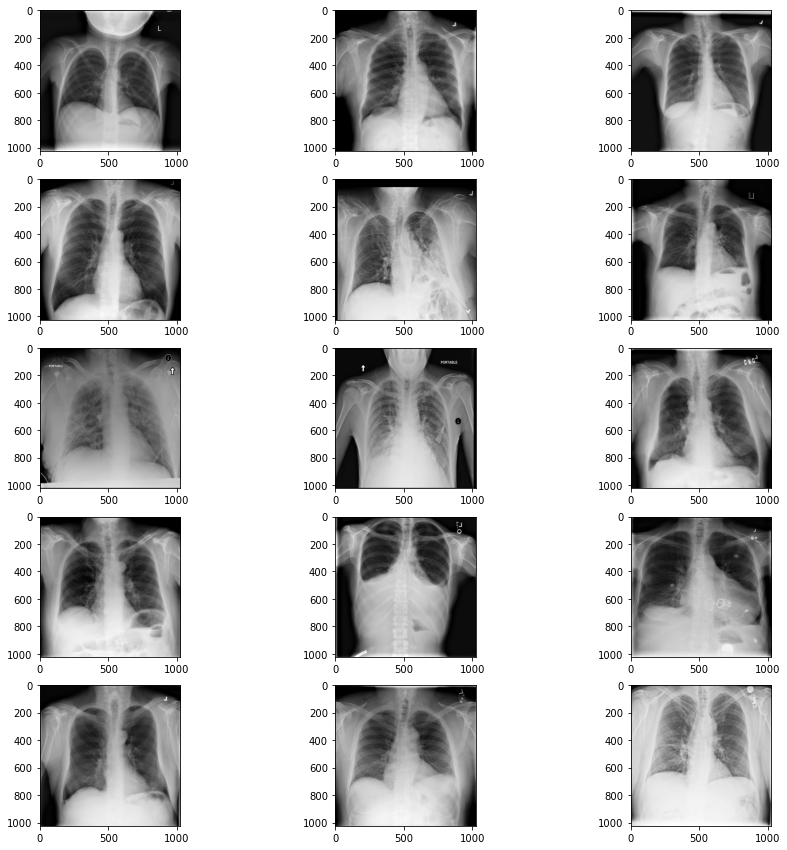

In [65]:
plt.figure(figsize=(15,15))

for i,j,k,l,m,n in zip((0,1,2), (1,2,3), (4,5,6), (7,8,9), (10,11,12), (13,14,15)):
    plt.subplot(5,3,j), plt.imshow(Pneumonia[i], cmap='gray')
    plt.subplot(5,3,k), plt.imshow(Infiltration[i], cmap='gray')
    plt.subplot(5,3,l), plt.imshow(Edema[i], cmap='gray')
    plt.subplot(5,3,m), plt.imshow(Effusion[i], cmap='gray')
    plt.subplot(5,3,n), plt.imshow(Atelectasis[i], cmap='gray')

In [66]:

samp_labels=np.unique(list(chain(*sample_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
samp_labels=[x for x in samp_labels if len(x)>0]
print(samp_labels)

for label in samp_labels:
    if len(label)>1:
        sample_df[label] = sample_df['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0)

        
sample_df.head()

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:

all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('data','images*', '*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', sample_df.shape[0])
sample_df['path'] = sample_df['Image Index'].map(all_image_paths.get)
sample_df.head()

Scans found: 0 , Total Headers 5606


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,path
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,None
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,None
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None


In [68]:
image_name = sample_df[sample_df['Pneumonia']==1]['Image Index'].sample().item()

In [69]:
image_paths = {os.path.basename(x): x for x in glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(image_paths), ', Total Headers', sample_df.shape[0])
sample_df['path'] = sample_df['Image Index'].map(image_paths.get)
sample_df.head()

def image_distribution(img_data):
    f = plt.figure()
    f.set_figwidth(10)
    s1 = f.add_subplot(1, 2, 1)
    s1.set_title('Image')
    plt.imshow(img_data, cmap='gray')
    s2 = f.add_subplot(1, 2, 2)
    s2.set_title('Intensity Distribution')
    plt.hist(img_data.ravel(), bins = 256)
    plt.xlim((10,255))
    plt.ylim((0,15000))
    plt.show()

Scans found: 112120 , Total Headers 5606


In [70]:
image_paths = {os.path.basename(x): x for x in glob(os.path.join('/data','images*', '*', '*.png'))}


def image_distribution(img_data):
    f = plt.figure()
    f.set_figwidth(10)
    s1 = f.add_subplot(1, 2, 1)
    s1.set_title('Image')
    plt.imshow(img_data, cmap='gray')
    s2 = f.add_subplot(1, 2, 2)
    s2.set_title('Intensity Distribution')
    plt.hist(img_data.ravel(), bins = 256)
    plt.xlim((10,255))
    plt.ylim((0,15000))
    plt.show()

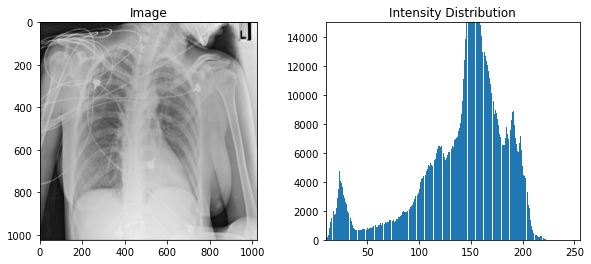

In [71]:
from skimage import io
img_data = io.imread(image_paths[image_name])
image_distribution(img_data)

Image Name 00003789_000.png


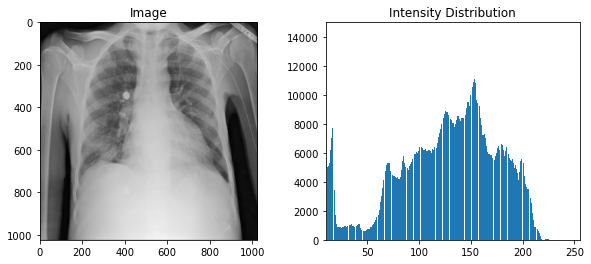

In [72]:
image_name = sample_df[sample_df['Pneumonia']==1]['Image Index'].sample().item()
print('Image Name', image_name)
img_data = io.imread(image_paths[image_name])
image_distribution(img_data)

Image Name 00012667_000.png


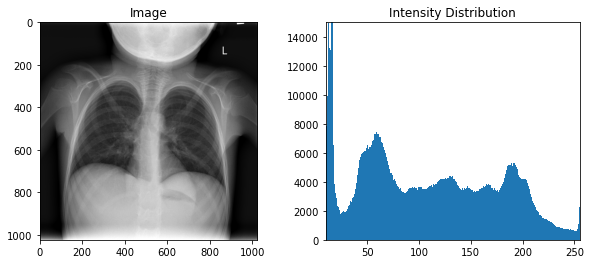

In [73]:
image_name = sample_df[sample_df['Pneumonia']==1]['Image Index'].sample().item()
print('Image Name', image_name)
img_data = io.imread(image_paths[image_name])
image_distribution(img_data)

Image Name 00016786_001.png


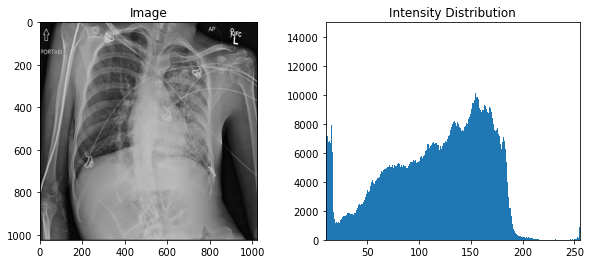

In [74]:
image_name = sample_df[sample_df['Pneumonia']==1]['Image Index'].sample().item()
print('Image Name', image_name)
img_data = io.imread(image_paths[image_name])
image_distribution(img_data)

Image Name 00008763_001.png


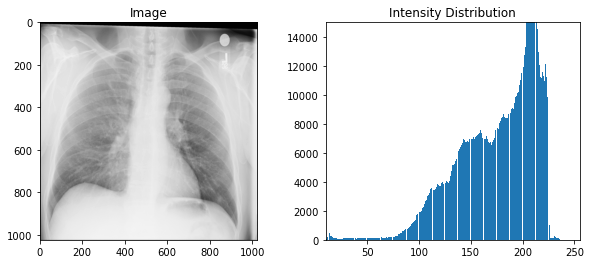

In [75]:
image_name = sample_df[sample_df['Pneumonia']==1]['Image Index'].sample().item()
print('Image Name', image_name)
img_data = io.imread(image_paths[image_name])
image_distribution(img_data)

Image Name 00001993_000.png


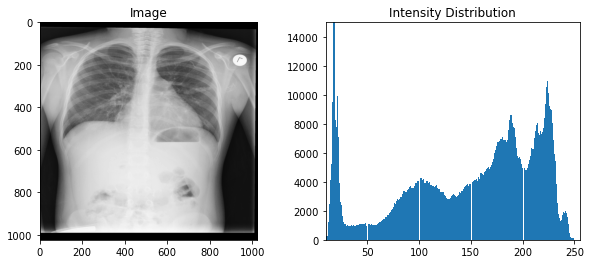

Image Name 00016786_001.png


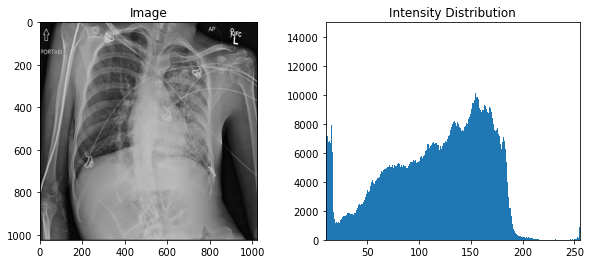

Image Name 00027725_073.png


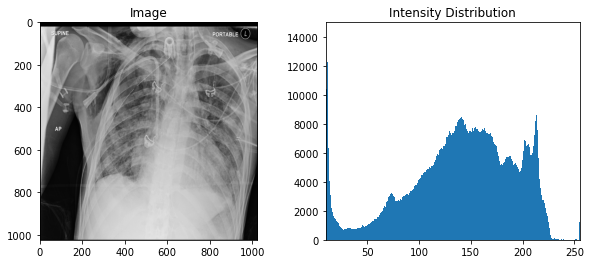

Image Name 00009953_025.png


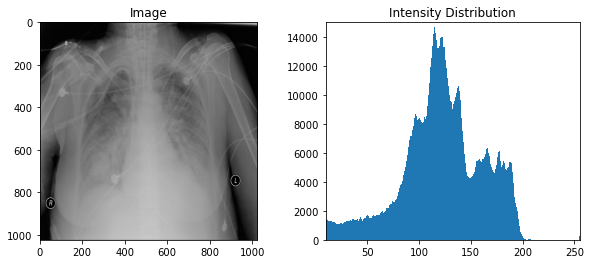

In [76]:
n = 4
for i in range(0, n):
    image_name = sample_df[sample_df['Pneumonia']==1]['Image Index'].sample().item()
    print('Image Name', image_name)
    img_data = io.imread(image_paths[image_name])
    image_distribution(img_data)

No pneumonia

Image Name 00011019_000.png


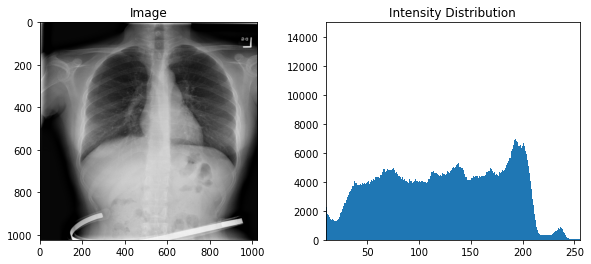

Image Name 00004526_007.png


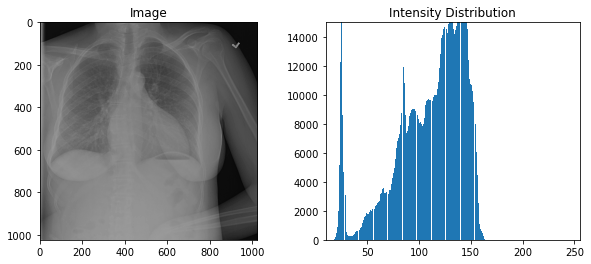

Image Name 00012276_017.png


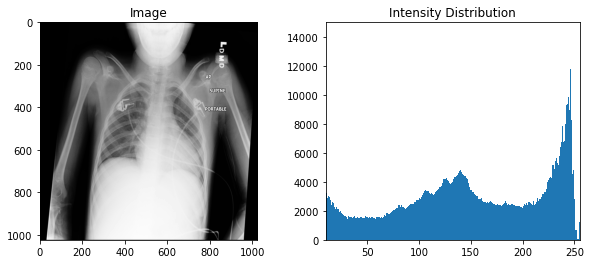

Image Name 00023033_010.png


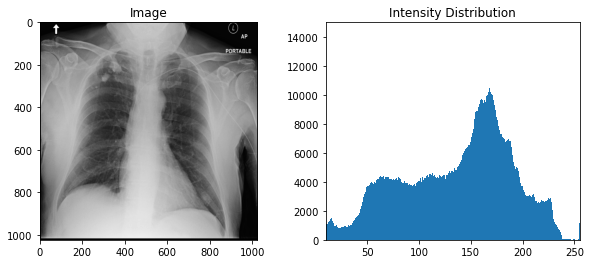

In [77]:
n = 4
for i in range(0, n):
    image_name = sample_df[sample_df['Pneumonia']==0]['Image Index'].sample().item()
    print('Image Name', image_name)
    img_data = io.imread(image_paths[image_name])
    image_distribution(img_data)

In [78]:
from matplotlib import image


00001373_010.png
00000061_025.png
00000061_025.png
00000061_019.png
00000116_040.png
00000816_000.png
00002412_000.png
00000242_000.png


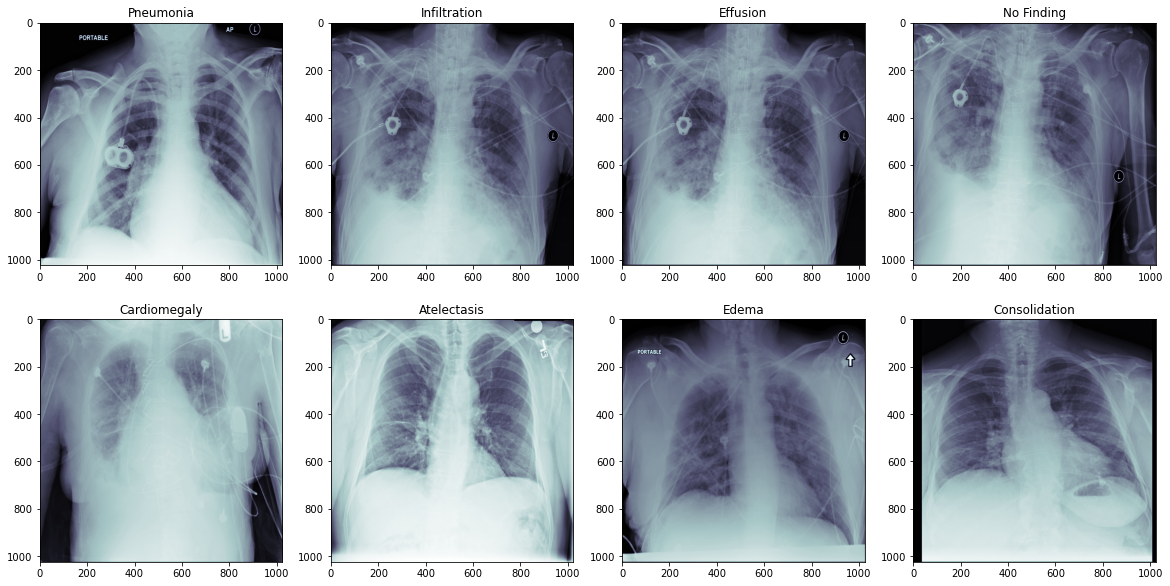

In [79]:
# the x rays for different lung conditions

subset=['Pneumonia','Infiltration','Effusion','No Finding', 'Cardiomegaly', 'Atelectasis','Edema','Consolidation']
fig, ax = plt.subplots(2, 4, figsize = (20, 10))
for i,s in enumerate(subset):
    filename=list(sample_df[sample_df[s]==1]['Image Index'])[i]
    print(filename)
    img_p=image.imread(image_paths[filename])
    j = (i // 4)
    if i > 3: i=i-4
    ax[j,i].set_title(s)
    ax[j,i].imshow(img_p, cmap='bone')
    
plt.show()

In [ ]:
# Pixel intensity distribution for different conditions

fig, pax = plt.subplots(2, 4, figsize = (20, 10))
for i,s in enumerate(subset):
    filename=list(sample_df[sample_df[s]==1]['Image Index'])[i]
    print(filename)
    img=image.imread(image_paths[filename])
    j = (i // 4)
    if i > 3: i = i-4
    pax[j,i].set_title(s)
    pax[j,i].hist(img)
plt.show()

00001373_010.png
00000061_025.png
00000061_025.png
00000061_019.png
00000116_040.png
00000816_000.png
00002412_000.png
00000242_000.png


In [ ]:
# Intensity distribution for different conditions

fig, bax = plt.subplots(2, 4, figsize = (20, 10))

for i,s in enumerate(subset):
    j = (i // 4)
    if i >3: i=i-4
    filename=list(sample_df[sample_df[s]==1]['path'])[3]

    img=image.imread(filename)
    img_copy = img.copy()
    mask = (img_copy > 0.1) & (img_copy < 0.9)
    
    img = img_copy[mask]
    bax[j,i].set_ylim(top=16000)
    bax[j,i].set_title(s)
    bax[j,i].hist(img.ravel(), bins=256)
    
plt.show()

In [ ]:

# Composite of Pneumonia

from PIL import Image

fimg1=list(sample_df[sample_df['Pneumonia']==1]['path'])[0]
fimg2=list(sample_df[sample_df['Pneumonia']==1]['path'])[1]
fimg3=list(sample_df[sample_df['Pneumonia']==1]['path'])[2]
img1=Image.open(fimg2)
img2=Image.open(fimg2)
mask=Image.open(fimg3).convert('L')
c_pneumonia=Image.composite(img1, img2, mask)

for fim in list(sample_df[sample_df['Pneumonia']==1]['path'])[3:25]:
    img=Image.open(fim)
    c_pneumonia=Image.composite(c_pneumonia, img, mask)

In [ ]:
# Composite of Infiltration

fimg1=list(sample_df[sample_df['Infiltration']==1]['path'])[0]
fimg2=list(sample_df[sample_df['Infiltration']==1]['path'])[1]
fimg3=list(sample_df[sample_df['Infiltration']==1]['path'])[2]
img1=Image.open(fimg2)
img2=Image.open(fimg2)
mask=Image.open(fimg3).convert('L')
c_infil=Image.composite(img1, img2, mask)

for fim in list(sample_df[sample_df['Infiltration']==1]['path'])[3:25]:
    img=Image.open(fim)
    c_infil=Image.composite(c_infil,img,mask)

In [ ]:
#composite of Effusion
from PIL import Image

fimg1=list(sample_df[sample_df['Effusion']==1]['path'])[0]
fimg2=list(sample_df[sample_df['Effusion']==1]['path'])[1]
fimg3=list(sample_df[sample_df['Effusion']==1]['path'])[2]
img1=Image.open(fimg2)
img2=Image.open(fimg2)
mask=Image.open(fimg3).convert('L')
c_effusion=Image.composite(img1,img2,mask)

for fim in list(sample_df[sample_df['Effusion']==1]['path'])[3:25]:
    img=Image.open(fim)
    c_effusion=Image.composite(c_effusion, img, mask)

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(18,6))

ax[0].hist(np.array(c_pneumonia).ravel(), bins=256)
ax[0].set_title("Pneumonia intensity distribution : Composite of 25 images")

ax[1].hist(np.array(c_infil).ravel(), bins=256)
ax[1].set_title("Infiltration intensity distribution : Composite of 25 images")

ax[2].hist(np.array(c_effusion).ravel(), bins=256)
ax[2].set_title("Effusion intensity distribution : Composite of 25 images")
plt.show()

In [ ]:
# Loading the sample data
images = []
for i, img_id in enumerate(sample_df['Image Index']):
    path = glob(os.path.join("../../data/pneumonia_data","images*","*",img_id))[0]
    img = io.imread(path)
    images.append(img)
print("Loaded {}/{}".format(i+1, len(sample_df)))

In [ ]:
intensity_images = []
for i, image in enumerate(images):
    intensity_images.append(np.mean(image))
intensity_images = np.array(intensity_images)
print("Loaded  {}/{}".format(i, len(images)))

In [ ]:
pneumonia_intensity = intensity_images[sample_df[sample_df["Finding Labels"].str.contains("Pneumonia")].index]
infiltration_intensity = intensity_images[sample_df[sample_df["Finding Labels"].str.contains("Infiltration")].index]
no_finding_intensity = intensity_images[sample_df[sample_df["Finding Labels"].str.contains("No Finding")].index]
sns.distplot(pneumonia_intensity, label = "Pneumonia");
sns.distplot(infiltration_intensity, label = "Infiltration");
sns.distplot(no_finding_intensity,label = "None");
plt.legend();

Conclusion

The intensity distribution for effusion, infiltration, pneumonia, and edema all have peaks near 110. Therefore pixel intensity distributions can not distinguish pneumonia from the presence of other diseases. However there are still a valuable tool in ruling out certain condidions and should be considered along with other lab reports and observations when diganosising a patient.